In [1]:
import json
import os
import math
import pandas as pd
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import matplotlib.patches as patches
from scipy.interpolate import make_interp_spline
import plotly.graph_objects as go

This notebook supports running in both **Google Colab** and **local environments**.

#### If running on **Google Colab**:
1. Make sure you have uploaded the full project to your Google Drive (e.g., `MyDrive/BACKUP/Urban_color_pipeline`).
2. Mount your Google Drive:
   ```python
   from google.colab import drive
   drive.mount('/content/drive')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/BACKUP/Urban_color_pipeline"
DATA_DIR = os.path.join(PROJECT_DIR, "data", "intermediate")
FINAL_DIR = os.path.join(PROJECT_DIR, "data", "final")

In [ ]:
cloudy = pd.read_csv(os.path.join(DATA_DIR, "cloudy.csv"))
print(cloudy.shape)
cloudy.head()

(56119, 4)


,longitude,latitude,image_direction,weather
0,114.117283,22.277437,Back,cloudy
1,114.117390,22.276340,Back,cloudy
2,114.117501,22.275971,Back,cloudy
3,114.117504,22.277757,Back,cloudy
4,114.117635,22.278120,Back,cloudy


In [ ]:
sunny=pd.read_csv(os.path.join(DATA_DIR, "sunny.csv"))
print(sunny.shape)
sunny.head()

(19733, 4)


,longitude,latitude,image_direction,weather
0,114.120350,22.280922,Back,sunny
1,114.120718,22.281040,Back,sunny
2,114.121062,22.281222,Back,sunny
3,114.121420,22.281373,Back,sunny
4,114.121795,22.281476,Back,sunny


In [ ]:
df_parquet = pd.read_parquet(os.path.join(DATA_DIR, "color_semantic_raw.parquet"))
print(df_parquet.shape)
df_parquet.head()

(75852, 1703)


,longitude,latitude,image_direction,id1_center0,id1_center1,id1_center2,id1_center3,id1_center4,id1_center5,id1_center6,...,id34_center40,id34_center41,id34_center42,id34_center43,id34_center44,id34_center45,id34_center46,id34_center47,id34_center48,id34_center49
0,114.189863736,22.346031009000058,Back,0.000078,0.001761,0.000000,0.0,0.000000,0.002393,0.001131,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,114.15273602900004,22.32911705300006,Front,0.000121,0.003425,0.000564,0.0,0.000000,0.001711,0.011560,...,0.0,0.000260,0.000355,0.000075,0.0,0.000286,0.000728,0.000049,0.000142,0.000460
2,113.95854915100004,22.31180495700005,Front,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000137,0.000000,0.000000,0.0,0.000000,0.000000,0.000003,0.000003,0.000157
3,114.17320440600008,22.34099398300004,Front,0.000260,0.002946,0.006879,0.0,0.016658,0.002078,0.000009,...,0.0,0.000023,0.000000,0.000017,0.0,0.000003,0.000012,0.000009,0.000014,0.000000
4,114.13943811100012,22.348875603000067,Front,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


# **Merging Colors (50 → 22)**

In [ ]:
with open(os.path.join(DATA_DIR, "50_color_info.json"), 'r') as f:
    color_info = json.load(f)
color_info

{'center0': {'RGB': [0.8515627980232239,
   0.8846258521080017,
   0.9110782146453857],
  'HLS': [206.66774153709412, 0.8813204765319824, 0.2507400387321256]},
 'center1': {'RGB': [0.35960447788238525,
   0.3672119081020355,
   0.3538578152656555],
  'HLS': [94.1802191734314, 0.3605348467826843, 0.01851983740925789]},
 'center2': {'RGB': [0.20906175673007965,
   0.2161942422389984,
   0.18752910196781158],
  'HLS': [74.92925316095352, 0.2018616795539856, 0.07100193947553635]},
 'center3': {'RGB': [0.3002763092517853,
   0.35839328169822693,
   0.17540696263313293],
  'HLS': [79.05616879463196, 0.26690012216567993, 0.34279924631118774]},
 'center4': {'RGB': [0.5429335236549377,
   0.4340991675853729,
   0.3419859707355499],
  'HLS': [27.50365376472473, 0.44245976209640503, 0.22708003222942352]},
 'center5': {'RGB': [0.3997562825679779,
   0.4051347076892853,
   0.39621251821517944],
  'HLS': [96.16886973381042, 0.40067362785339355, 0.01113398652523756]},
 'center6': {'RGB': [0.353280395

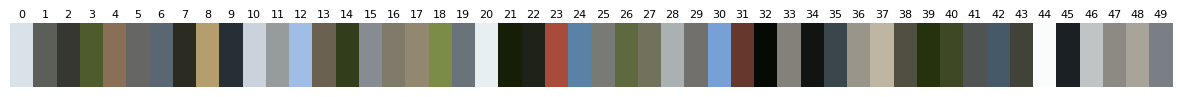

In [ ]:
centers_rgb = [color_info.get(f'center{i}')['RGB'] for i in range(50)]
def plot_color_card(centers_rgb):
    fig, ax = plt.subplots(figsize=(15, 1))

    num_colors = len(centers_rgb)
    x = np.arange(num_colors)

    for i, rgb in enumerate(centers_rgb):
        ax.bar(x[i], 1, color=rgb, width=1, edgecolor='none')

    for i in range(num_colors):
        ax.text(i, 1.05, f'{i}', ha='center', va='bottom', fontsize=8)

    ax.set_xlim(-0.5, num_colors - 0.5)
    ax.set_ylim(0, 1.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

    plt.show()

plot_color_card(centers_rgb)

## Define Color Difference Function

In [ ]:
# Input Lab values of two colors. Output their color difference.
def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7

    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))

    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2

    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)

    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi

    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)

    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2

    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_

    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi
    else: h_ave = h1_ + h2_

    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)

    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))

    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T

    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1

    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H

    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00

## Try various thresholds.

Processing threshold = 0
color_groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49]]


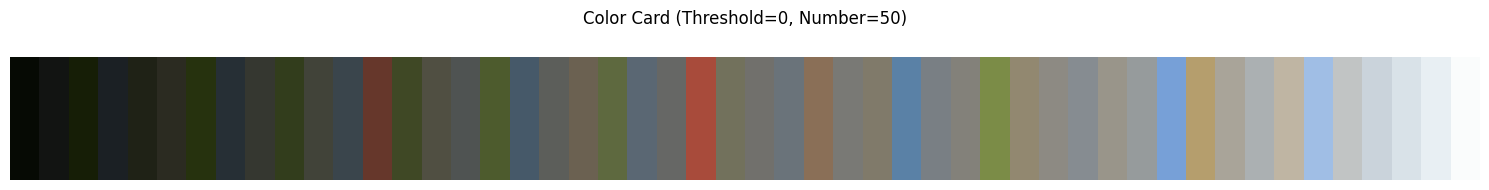

Processing threshold = 1
color_groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49]]


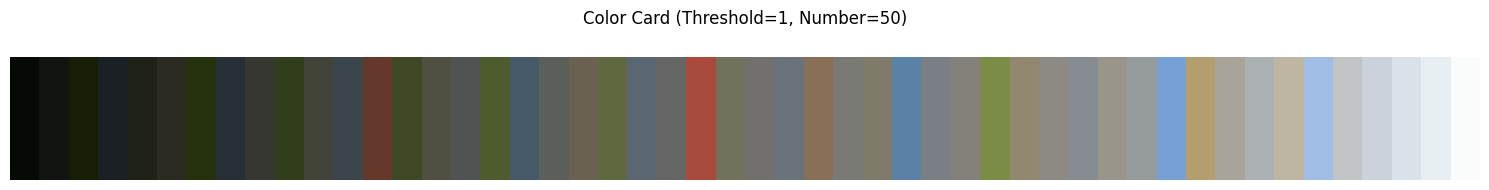

Processing threshold = 2
color_groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49]]


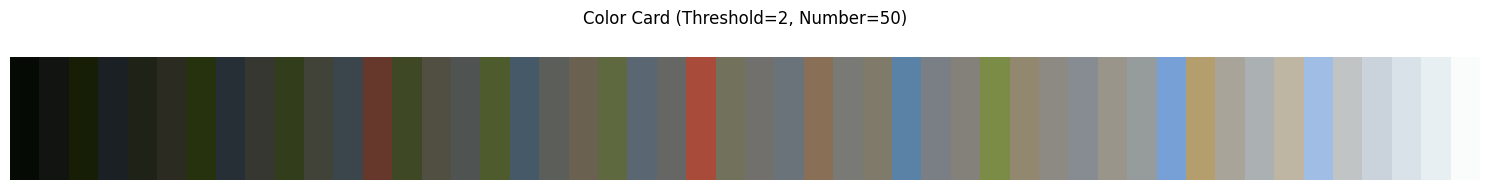

Processing threshold = 3
color_groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32, 34], [33], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49]]


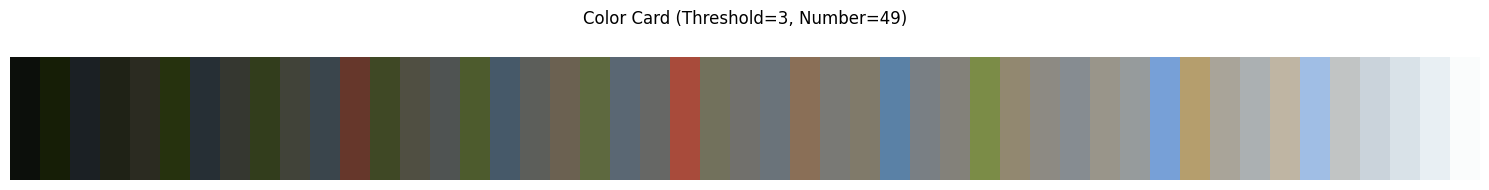

Processing threshold = 4
color_groups: [[0, 10, 20], [1, 5], [2, 43], [3], [4], [6], [7, 22], [8], [9], [11], [12], [13], [14, 39, 40], [15], [16], [17], [18], [19], [21], [23], [24], [25, 29, 33], [26], [27], [28], [30], [31], [32, 34], [35], [36], [37], [38], [41], [42], [44], [45], [46], [47], [48], [49]]


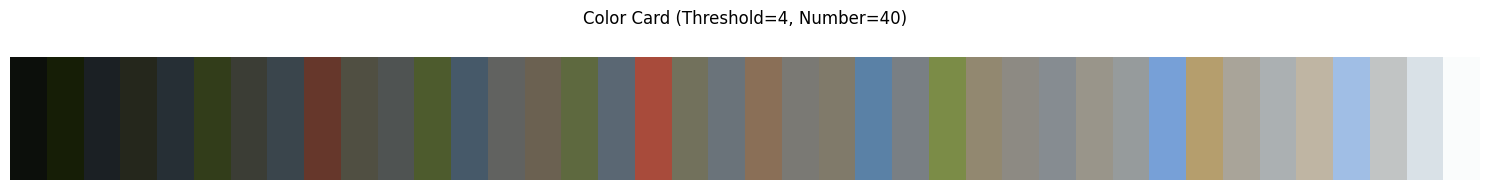

Processing threshold = 5
color_groups: [[0, 10, 20], [1, 5, 41], [2, 7, 43], [3], [4], [6], [8], [9, 45], [11], [12], [13], [14, 39, 40], [15, 49], [16], [17], [18], [19], [21], [22], [23], [24], [25, 29, 33], [26], [27], [28], [30], [31], [32, 34], [35], [36, 47, 48], [37], [38], [42], [44], [46]]


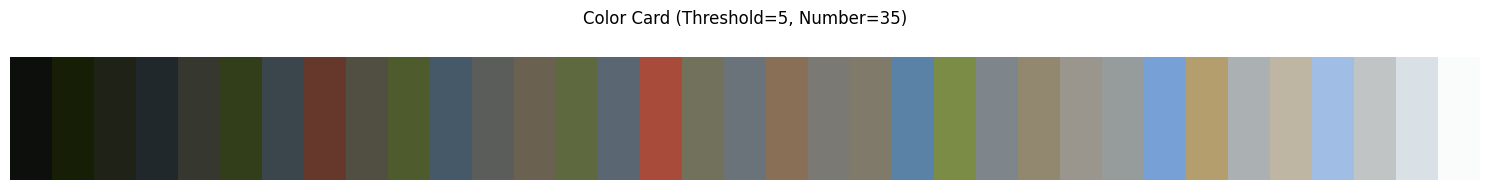

Processing threshold = 6
color_groups: [[0, 10, 20], [1, 5, 41], [2, 7, 43], [3, 26], [4], [6, 19], [8], [9, 45], [11, 15], [12], [13], [14, 39, 40], [16, 27, 33], [17], [18], [21, 22], [23], [24], [25, 29, 49], [28, 46], [30], [31], [32, 34], [35], [36, 47, 48], [37], [38], [42], [44]]


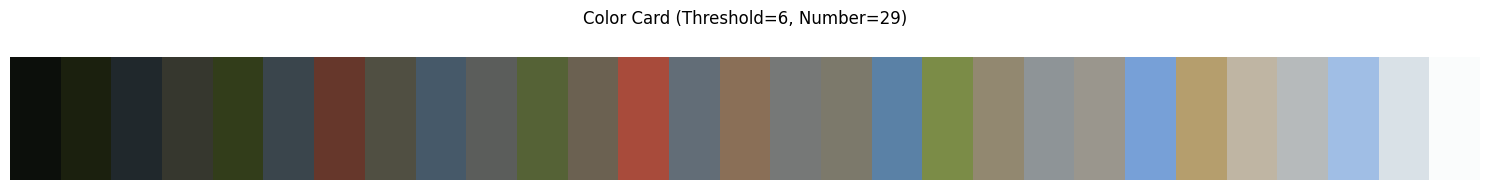

Processing threshold = 7
color_groups: [[0, 10, 20, 44], [1, 5, 41], [2, 7, 43], [3, 26, 40], [4], [6, 19, 42], [8], [9, 35, 45], [11, 15, 28], [12], [13], [14, 39], [16, 17, 25, 27, 33], [18], [21, 22], [23], [24], [29], [30], [31], [32, 34], [36, 47, 48], [37], [38], [46], [49]]


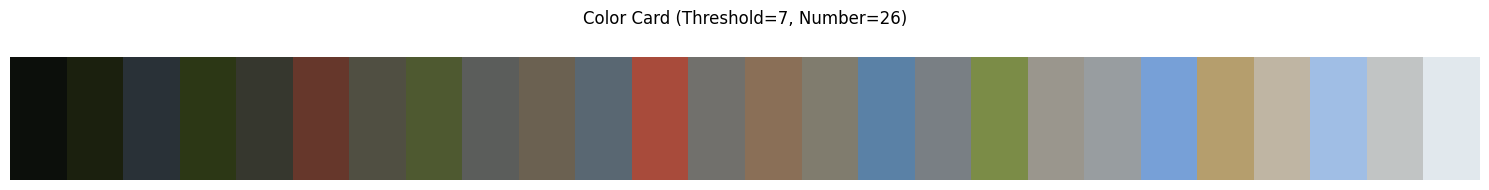

Processing threshold = 8
color_groups: [[0, 10, 20, 44, 46], [1, 5, 29, 38, 41], [2, 7, 22, 43], [3, 26, 40], [4], [6, 19, 42], [8], [9, 35, 45], [11, 15, 28, 36, 47, 48], [12], [13, 27], [14, 39], [16, 17, 25, 33], [18], [21], [23], [24], [30], [31], [32, 34], [37], [49]]


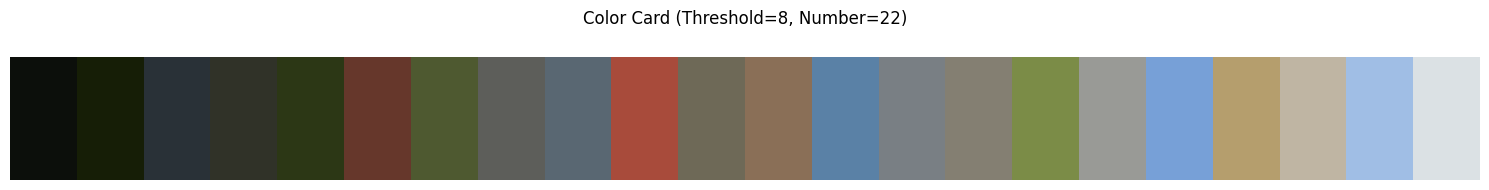

Processing threshold = 9
color_groups: [[0, 10, 20, 44, 46], [1, 5, 13, 29, 38, 41], [2, 7, 9, 22, 43], [3, 26, 40], [4], [6, 19, 42], [8], [11, 15, 28, 36, 47, 48], [12], [14, 39], [16, 17, 25, 27, 33], [18], [21], [23], [24], [30], [31], [32, 34, 45], [35], [37], [49]]


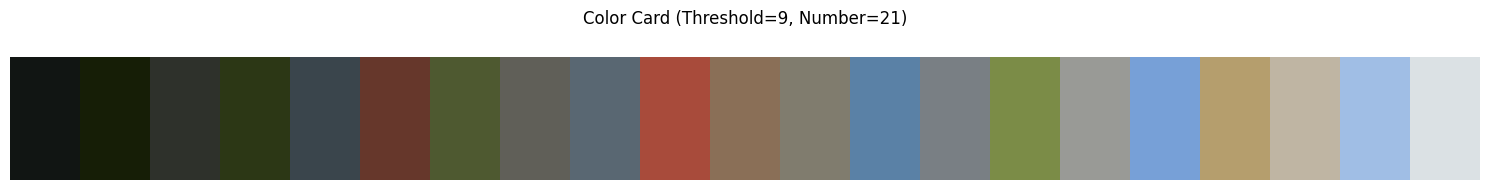

In [ ]:
# RGB to LAB
def rgb_to_lab(rgb):
    rgb = np.array(rgb).reshape(1, 1, 3)
    lab = color.rgb2lab(rgb)
    return tuple(lab[0, 0])

# Merge similar colors based on threshold
def merge_similar_colors(centers_rgb, threshold):
    centers_lab = [rgb_to_lab(rgb) for rgb in centers_rgb]

    merged_colors = []
    color_groups = []
    used_indices = set()

    for i, lab1 in enumerate(centers_lab):
        if i in used_indices:
            continue
        merged = [centers_rgb[i]]
        group_indices = [i]
        for j, lab2 in enumerate(centers_lab[i+1:], start=i+1):
            if j not in used_indices and CIEDE2000(lab1, lab2) < threshold:
                merged.append(centers_rgb[j])
                group_indices.append(j)
                used_indices.add(j)

        avg_color = np.mean(merged, axis=0)
        merged_colors.append(avg_color)
        color_groups.append(group_indices)

    print(f"color_groups: {color_groups}")
    return merged_colors, color_groups

# Sort by lightness (L from LAB)
def sort_colors_by_lightness(centers_rgb):
    centers_lab = [rgb_to_lab(rgb) for rgb in centers_rgb]
    sorted_indices = np.argsort([lab[0] for lab in centers_lab])
    return [centers_rgb[i] for i in sorted_indices]

# Unified plotting function with sorting
def plot_color_card(centers_rgb, my_threshold, save_path=None, sort_by_lightness=True):
    if sort_by_lightness:
        centers_rgb = sort_colors_by_lightness(centers_rgb)

    fig, ax = plt.subplots(figsize=(15, 2))
    num_colors = len(centers_rgb)
    x = np.arange(num_colors)

    for i, rgb in enumerate(centers_rgb):
        ax.bar(x[i], 1, color=rgb, width=1, edgecolor='none')

    ax.set_xlim(-0.5, num_colors - 0.5)
    ax.set_ylim(0, 1.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Color Card (Threshold={my_threshold}, Number={num_colors})")
    ax.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# Run for multiple thresholds
for test_threshold in range(0, 10):
    print(f"Processing threshold = {test_threshold}")
    merged_centers_rgb, color_groups = merge_similar_colors(centers_rgb, test_threshold)
    plot_color_card(merged_centers_rgb, test_threshold, sort_by_lightness=True)


## We take threshold = 8 with 22 merged colors

color_groups: [[0, 10, 20, 44, 46], [1, 5, 29, 38, 41], [2, 7, 22, 43], [3, 26, 40], [4], [6, 19, 42], [8], [9, 35, 45], [11, 15, 28, 36, 47, 48], [12], [13, 27], [14, 39], [16, 17, 25, 33], [18], [21], [23], [24], [30], [31], [32, 34], [37], [49]]


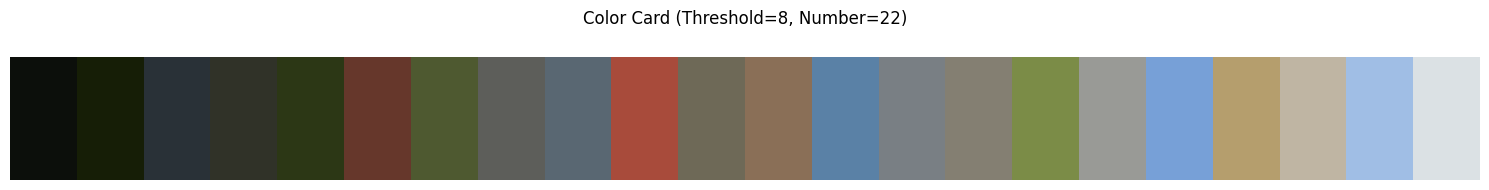

In [ ]:
final_threshold = 8
final_merged_centers_rgb, final_color_groups = merge_similar_colors(centers_rgb, final_threshold)
plot_color_card(final_merged_centers_rgb, final_threshold)

In [ ]:
final_color_groups

[[0, 10, 20, 44, 46],
 [1, 5, 29, 38, 41],
 [2, 7, 22, 43],
 [3, 26, 40],
 [4],
 [6, 19, 42],
 [8],
 [9, 35, 45],
 [11, 15, 28, 36, 47, 48],
 [12],
 [13, 27],
 [14, 39],
 [16, 17, 25, 33],
 [18],
 [21],
 [23],
 [24],
 [30],
 [31],
 [32, 34],
 [37],
 [49]]

In [ ]:
final_merged_centers_rgb

[array([0.85842422, 0.88146807, 0.89578145]),
 array([0.3655782 , 0.36958849, 0.35116445]),
 array([0.18895569, 0.19520347, 0.15700801]),
 array([0.30514307, 0.35030171, 0.18992084]),
 array([0.54293352, 0.43409917, 0.34198597]),
 array([0.34743249, 0.40202294, 0.44753295]),
 array([0.7079069 , 0.62056142, 0.42585555]),
 array([0.16037703, 0.19405693, 0.21602263]),
 array([0.59978366, 0.60227739, 0.58897006]),
 array([0.62598443, 0.74526888, 0.89729053]),
 array([0.43234684, 0.41124953, 0.33934394]),
 array([0.17113037, 0.21695919, 0.0814257 ]),
 array([0.51639039, 0.49807709, 0.44849223]),
 array([0.4806914 , 0.54762572, 0.27781412]),
 array([0.08574285, 0.11711839, 0.02425088]),
 array([0.65744919, 0.29290077, 0.23022212]),
 array([0.35460433, 0.50627798, 0.65104073]),
 array([0.46692258, 0.62673688, 0.84506243]),
 array([0.40143967, 0.21641798, 0.16936915]),
 array([0.04799178, 0.05900909, 0.04411795]),
 array([0.75073719, 0.71077234, 0.63884616]),
 array([0.47283062, 0.49985856, 0.

In [ ]:
# Function to convert RGB values (0–1 range) to HEX string using rounding
def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(
        round(rgb[0] * 255),
        round(rgb[1] * 255),
        round(rgb[2] * 255)
    )

# Create a dictionary with HEX values appended to the RGB list
merged_color_info_with_hex = {
    f'center{i}': rgb + [rgb_to_hex(rgb)]
    for i, rgb in enumerate([center.tolist() for center in final_merged_centers_rgb])
}

# Define the output path for RGB + HEX
output_with_hex_path = os.path.join(FINAL_DIR, 'merged_color_info_with_hex.json')

# Save the dictionary with HEX to a JSON file
with open(output_with_hex_path, 'w') as f:
    json.dump(merged_color_info_with_hex, f, indent=4)

output_with_hex_path, merged_color_info_with_hex

('/content/drive/MyDrive/BACKUP/Urban_color_pipeline/data/final/merged_color_info_with_hex.json',
 {'center0': [0.8584242224693298,
   0.8814680695533752,
   0.8957814455032349,
   '#dbe1e4'],
  'center1': [0.36557820439338684,
   0.3695884943008423,
   0.3511644542217255,
   '#5d5e5a'],
  'center2': [0.18895569443702698,
   0.19520347192883492,
   0.15700801461935043,
   '#303228'],
  'center3': [0.3051430682341258,
   0.35030171275138855,
   0.1899208426475525,
   '#4e5930'],
  'center4': [0.5429335236549377,
   0.4340991675853729,
   0.3419859707355499,
   '#8a6f57'],
  'center5': [0.3474324941635132,
   0.40202293793360394,
   0.4475329518318176,
   '#596772'],
  'center6': [0.7079069018363953,
   0.620561420917511,
   0.4258555471897125,
   '#b59e6d'],
  'center7': [0.1603770280877749,
   0.1940569281578064,
   0.21602262556552887,
   '#293137'],
  'center8': [0.5997836589813232,
   0.6022773881753286,
   0.5889700551827749,
   '#999a96'],
  'center9': [0.6259844303131104,
   0.74

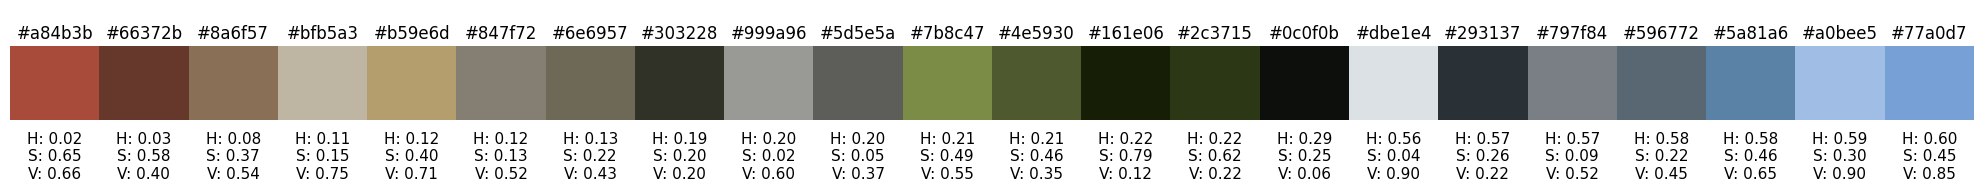

In [ ]:
# Convert RGB to HSV (expects values in 0–1 range)
def rgb_to_hsv(rgb):
    return colorsys.rgb_to_hsv(rgb[0], rgb[1], rgb[2])

# Compute HSV list and retain original index
my_hsv_colors = []
for i, rgb_color in enumerate(final_merged_centers_rgb):
    hsv_color = rgb_to_hsv(rgb_color)
    my_hsv_colors.append((hsv_color, i))  # (HSV, index)

# Sort by hue
my_hsv_colors.sort(key=lambda x: x[0][0])

# Prepare plot
fig, ax = plt.subplots(figsize=(20, 2))
num_colors = len(my_hsv_colors)
x = np.arange(num_colors)

for i, (hsv_color, color_id) in enumerate(my_hsv_colors):
    # Convert HSV back to RGB (for display)
    rgb_color = colorsys.hsv_to_rgb(*hsv_color)

    # Retrieve HEX code from merged info
    center_key = f"center{color_id}"
    hex_color = merged_color_info_with_hex.get(center_key, [None, None, None, '#000000'])[-1]

    # Draw color bar
    ax.bar(x[i], 1, color=rgb_color, width=1, edgecolor='none')

    # Display HEX code above
    ax.text(i, 1.05, hex_color, ha='center', va='bottom', fontsize=12)

    # Display HSV values below
    h, s, v = hsv_color
    ax.text(i, -0.15, f'H: {h:.2f}\nS: {s:.2f}\nV: {v:.2f}',
            ha='center', va='top', fontsize=11)

# Formatting
ax.set_xlim(-0.5, num_colors - 0.5)
ax.set_ylim(-0.4, 1.5)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

plt.tight_layout()

# Save figure
plt.savefig(os.path.join(FINAL_DIR, 'merged_color_card_sorted_by_hue.png'), dpi=300, bbox_inches='tight')
plt.show()

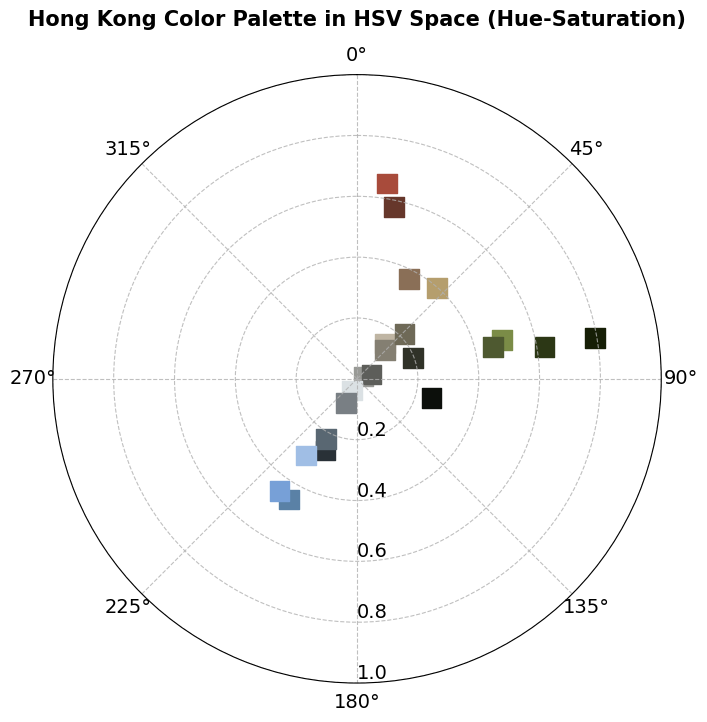

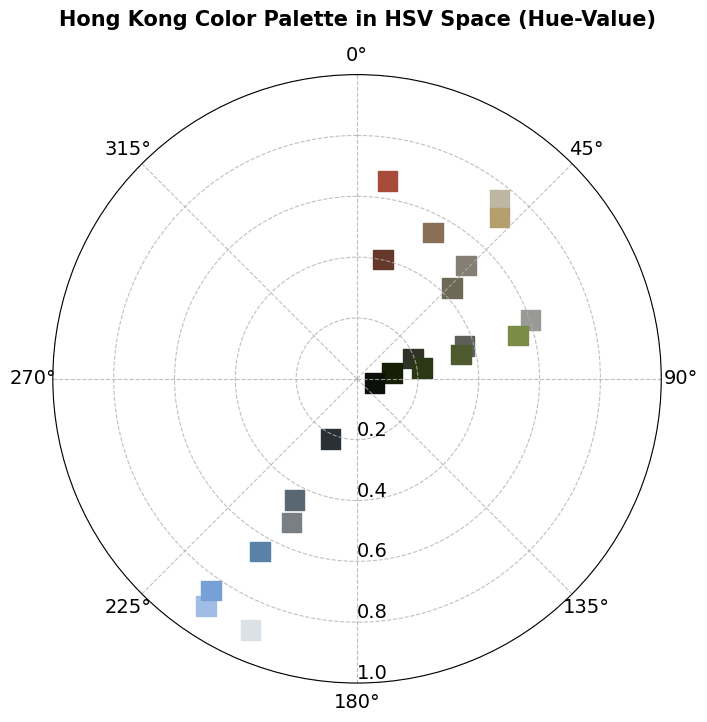

In [ ]:
# Extract HSV components
h_values = [h for (h, s, v), _ in my_hsv_colors]
s_values = [s for (h, s, v), _ in my_hsv_colors]
v_values = [v for (h, s, v), _ in my_hsv_colors]
rgb_colors = [colorsys.hsv_to_rgb(h, s, v) for h, s, v in zip(h_values, s_values, v_values)]

# Function to plot polar HSV graph
def plot_hsv_polar(theta, radius, rgb_colors, label, save_path):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.scatter(theta, radius, c=rgb_colors, s=200, zorder=1, marker="s")
    ax.set_title(
        f"Hong Kong Color Palette in HSV Space (Hue-{label})",
        fontsize=15, fontweight='bold', pad=35
    )
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(180)
    ax.grid(True, linestyle='--', alpha=0.8)
    ax.set_rlim(0, 1)
    ax.tick_params(labelsize=14)
    plt.subplots_adjust(top=0.9)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Convert to polar coordinates and plot both versions
theta = 2 * np.pi * np.array(h_values)

# Hue-Saturation Plot
plot_hsv_polar(theta, np.array(s_values), rgb_colors, "Saturation",
               os.path.join(FINAL_DIR, 'palette_hsv_polar_hue_saturation.png'))

# Hue-Value Plot
plot_hsv_polar(theta, np.array(v_values), rgb_colors, "Value",
               os.path.join(FINAL_DIR, "palette_hsv_polar_hue_value.png"))


In [ ]:
metadata_cols = ['longitude', 'latitude', 'image_direction']

new_color_features = {}

for semantic in range(1, 35):
    for new_center, group in enumerate(final_color_groups):

        old_cols = [f"id{semantic}_center{old_center}" for old_center in group]
        new_col_name = f"id{semantic}_center{new_center}"

        new_color_features[new_col_name] = df_parquet[old_cols].sum(axis=1)

df_new_features = pd.DataFrame(new_color_features, index=df_parquet.index)

df_color_merged = pd.concat([df_parquet[metadata_cols], df_new_features], axis=1)

df_color_merged = df_color_merged.copy()

print("Merge Color Attributes Successfully")

Merge Color Attributes Successfully


In [ ]:
color_merged_sum = df_color_merged.drop(columns=metadata_cols).sum(axis=1)
print(color_merged_sum.describe())
print(df_color_merged.shape)
df_color_merged.head()

count    7.585200e+04
mean     1.000000e+00
std      6.008852e-16
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64
(75852, 751)


,longitude,latitude,image_direction,id1_center0,id1_center1,id1_center2,id1_center3,id1_center4,id1_center5,id1_center6,...,id34_center12,id34_center13,id34_center14,id34_center15,id34_center16,id34_center17,id34_center18,id34_center19,id34_center20,id34_center21
0,114.189863736,22.346031009000058,Back,0.001425,0.006886,0.000003,0.000007,0.000000,0.002429,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,114.15273602900004,22.32911705300006,Front,0.019738,0.011739,0.001165,0.000000,0.000000,0.031610,0.000000,...,0.000171,0.0,0.0,0.0,0.0,0.0,0.0,0.000977,0.0,0.000460
2,113.95854915100004,22.31180495700005,Front,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000043,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000157
3,114.17320440600008,22.34099398300004,Front,0.002185,0.021396,0.023645,0.000237,0.016658,0.000067,0.000069,...,0.000014,0.0,0.0,0.0,0.0,0.0,0.0,0.000014,0.0,0.000000
4,114.13943811100012,22.348875603000067,Front,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


# **Merging Semantics (34 → 18)**

## Initial Categories: 34

In [ ]:
with open(os.path.join(DATA_DIR, "34_semantic_info.json"), 'r') as f:
    semantic_info = json.load(f)
semantic_info

{'id1': 'building',
 'id2': 'road',
 'id3': 'sidewalk',
 'id4': 'overpass',
 'id5': 'tunnel',
 'id6': 'sky',
 'id7': 'tree',
 'id8': 'grass',
 'id9': 'shrub',
 'id10': 'flower bed',
 'id11': 'rock',
 'id12': 'soil',
 'id13': 'mountain',
 'id14': 'sea',
 'id15': 'awning',
 'id16': 'pole',
 'id17': 'fence',
 'id18': 'bench',
 'id19': 'dustbin',
 'id20': 'kiosk',
 'id21': 'streetlight',
 'id22': 'traffic light',
 'id23': 'traffic cone',
 'id24': 'traffic barrier',
 'id25': 'billboard',
 'id26': 'store sign',
 'id27': 'signpost',
 'id28': 'traffic sign',
 'id29': 'pedestrian',
 'id30': 'motorcycle',
 'id31': 'car',
 'id32': 'bus',
 'id33': 'tram',
 'id34': 'truck'}

## Merged categories: 18

  

#### Man-made background (5)

- "building": 1
- "road": 2
- "sidewalk": 3
- "overpass": 4
- "tunnel": 5

#### Natural background (4)

- "sky": 6
- “vegetation”
    - "tree": 7
    - "grass": 8
    - "shrub": 9
    - "flower bed": 10
- “terrain”
    - "rock": 11
    - "soil": 12
    - "mountain": 13
- "sea": 14

#### Static Decoration (3)

- “street furniture”
    - "awning": 15
    - "pole": 16
    - "fence": 17
    - "bench": 18
    - "dustbin": 19
    - "kiosk": 20
- “traffic equipment”
    - "streetlight": 21
    - "traffic light": 22
    - "traffic cone": 23
    - "traffic barrier": 24
    - "signpost": 27
    - "traffic sign": 28
- “commercial signboard”
    - "billboard": 25
    - "store sign": 26

#### Dynamic Decoration (6)

- "pedestrian": 29
- "motorcycle": 30
- "car": 31
- "bus": 32
- "tram": 33
- "truck": 34

In [ ]:
semantic_groups = [
    [1],  # 1 building
    [2],  # 2 road
    [3],  # 3 sidewalk
    [4],  # 4 overpass
    [5],  # 5 tunnel
    [6],  # 6 sky
    [7, 8, 9, 10],  # 7 vegetation
    [11, 12, 13],  # 8 terrain
    [14],  # 9 sea
    [15, 16, 17, 18, 19, 20],  # 10 street furniture
    [21, 22, 23, 24, 27, 28],  # 11 traffic equipment
    [25, 26],  # 12 commercial signboard
    [29],  # 13 pedestrian
    [30],  # 14 motorcycle
    [31],  # 15 car
    [32],  # 16 bus
    [33],  # 17 tram
    [34]  # 18 truck
]

In [ ]:
# Create the merged semantic info dictionary
merged_semantic_info = {
    'id1': 'building',
    'id2': 'road',
    'id3': 'sidewalk',
    'id4': 'overpass',
    'id5': 'tunnel',
    'id6': 'sky',
    'id7': 'vegetation',
    'id8': 'terrain',
    'id9': 'sea',
    'id10': 'street furniture',
    'id11': 'traffic equipment',
    'id12': 'commercial signboard',
    'id13': 'pedestrian',
    'id14': 'motorcycle',
    'id15': 'car',
    'id16': 'bus',
    'id17': 'tram',
    'id18': 'truck'
}
# Define the output file path for the merged JSON file
output_file_path = os.path.join(FINAL_DIR, "merged_semantic_info.json")

# Save the merged semantic info to JSON
with open(output_file_path, 'w') as f:
    json.dump(merged_semantic_info, f, indent=4)

output_file_path
merged_semantic_info

{'id1': 'building',
 'id2': 'road',
 'id3': 'sidewalk',
 'id4': 'overpass',
 'id5': 'tunnel',
 'id6': 'sky',
 'id7': 'vegetation',
 'id8': 'terrain',
 'id9': 'sea',
 'id10': 'street furniture',
 'id11': 'traffic equipment',
 'id12': 'commercial signboard',
 'id13': 'pedestrian',
 'id14': 'motorcycle',
 'id15': 'car',
 'id16': 'bus',
 'id17': 'tram',
 'id18': 'truck'}

In [ ]:
new_semantic_features = {}

for new_sem_index, sem_group in enumerate(semantic_groups):
    new_sem_id = new_sem_index + 1  # 需要+1，新语义ids: id1, id2, ..., id18
    for color in range(22):

        old_cols = [f"id{orig_sem}_center{color}" for orig_sem in sem_group]
        new_col_name = f"id{new_sem_id}_center{color}"

        new_semantic_features[new_col_name] = df_color_merged[old_cols].sum(axis=1)


df_semantic_features = pd.DataFrame(new_semantic_features, index=df_color_merged.index)


df_color_semantic_merged = pd.concat([df_color_merged[metadata_cols], df_semantic_features], axis=1)

df_color_semantic_merged = df_color_semantic_merged.copy()

print("Merge Semantic Attributes Successfully")

Merge Semantic Attributes Successfully


In [ ]:
color_semantic_merged_sum = df_color_semantic_merged.drop(columns=metadata_cols).sum(axis=1)
print(color_semantic_merged_sum.describe())
print(df_color_semantic_merged.shape)
df_color_semantic_merged.head()

count    7.585200e+04
mean     1.000000e+00
std      4.432211e-16
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64
(75852, 399)


,longitude,latitude,image_direction,id1_center0,id1_center1,id1_center2,id1_center3,id1_center4,id1_center5,id1_center6,...,id18_center12,id18_center13,id18_center14,id18_center15,id18_center16,id18_center17,id18_center18,id18_center19,id18_center20,id18_center21
0,114.189863736,22.346031009000058,Back,0.001425,0.006886,0.000003,0.000007,0.000000,0.002429,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,114.15273602900004,22.32911705300006,Front,0.019738,0.011739,0.001165,0.000000,0.000000,0.031610,0.000000,...,0.000171,0.0,0.0,0.0,0.0,0.0,0.0,0.000977,0.0,0.000460
2,113.95854915100004,22.31180495700005,Front,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000043,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000157
3,114.17320440600008,22.34099398300004,Front,0.002185,0.021396,0.023645,0.000237,0.016658,0.000067,0.000069,...,0.000014,0.0,0.0,0.0,0.0,0.0,0.0,0.000014,0.0,0.000000
4,114.13943811100012,22.348875603000067,Front,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


# **Add weather attribute**

In [ ]:
# Concatenate sunny and cloudy dataframes to create a single weather dataframe
weather_df = pd.concat([sunny, cloudy], ignore_index=True)

# Convert the 'longitude' and 'latitude' columns in df_color_semantic_merged to float64
df_color_semantic_merged['longitude'] = df_color_semantic_merged['longitude'].astype(float)
df_color_semantic_merged['latitude'] = df_color_semantic_merged['latitude'].astype(float)


# Merge df_color_semantic_merged with weather_df on the specified columns
df_with_weather = pd.merge(df_color_semantic_merged, weather_df[['longitude', 'latitude', 'image_direction', 'weather']],
                           on=['longitude', 'latitude', 'image_direction'],
                           how='left')

print("Weather information added to df_color_semantic_merged.")
df_with_weather.to_parquet(os.path.join(FINAL_DIR, 'color_semantic_merged_with_weather.parquet'))
print(df_with_weather.shape)
display(df_with_weather.head())

Weather information added to df_color_semantic_merged.
(75852, 400)


,longitude,latitude,image_direction,id1_center0,id1_center1,id1_center2,id1_center3,id1_center4,id1_center5,id1_center6,...,id18_center13,id18_center14,id18_center15,id18_center16,id18_center17,id18_center18,id18_center19,id18_center20,id18_center21,weather
0,114.189864,22.346031,Back,0.001425,0.006886,0.000003,0.000007,0.000000,0.002429,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,cloudy
1,114.152736,22.329117,Front,0.019738,0.011739,0.001165,0.000000,0.000000,0.031610,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000977,0.0,0.000460,cloudy
2,113.958549,22.311805,Front,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000157,cloudy
3,114.173204,22.340994,Front,0.002185,0.021396,0.023645,0.000237,0.016658,0.000067,0.000069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000014,0.0,0.000000,cloudy
4,114.139438,22.348876,Front,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,cloudy


# **Display color by Sankey chart**

In [ ]:
!pip install plotly

In [ ]:
def plot_selected_semantic_color_sankey(weather, selected_semantics=None, selected_colors=None):
    # Load and filter data
    df = pd.read_parquet(os.path.join(FINAL_DIR, 'color_semantic_merged_with_weather.parquet'))
    if weather.lower() != "all":
        df = df[df['weather'] == weather.lower()]

    # Default selections
    all_semantics = list(range(1, 19))
    all_colors = list(range(26))
    selected_semantics = selected_semantics or all_semantics
    selected_colors = selected_colors or all_colors

    # Get semantic names and IDs
    semantic_names = [merged_semantic_info[f"id{sem}"] for sem in selected_semantics]
    semantic_ids = [str(sem) for sem in selected_semantics]

    # Get color hex codes
    color_hexes = [merged_color_info_with_hex[f"center{col}"][3] for col in selected_colors]

    # Create title components
    semi_title = "All 18 Semantics" if len(selected_semantics) == 18 else f"{len(selected_semantics)} Semantics"
    color_title = "All 26 Colors" if len(selected_colors) == 26 else f"{len(selected_colors)} Colors"

    # Shorten long lists for display
    def shorten_list(items, max_display=3):
        if len(items) <= max_display:
            return ", ".join(items)
        return ", ".join(items[:max_display]) + f", +{len(items)-max_display}"

    # Generate detailed title
    title_parts = []
    if len(selected_semantics) < 18:
        title_parts.append(f"Semantics: {shorten_list(semantic_names)}")
    if len(selected_colors) < 26:
        title_parts.append(f"Colors: {shorten_list(color_hexes)}")

    subtitle = "<br>".join(title_parts) if title_parts else "All Semantic Classes and Colors"

    # Create filename components
    semi_label = "all_sem" if len(selected_semantics) == 18 else "_".join(semantic_ids)
    color_label = "all_col" if len(selected_colors) == 26 else "_".join([h.replace("#", "") for h in color_hexes])

    # Data processing
    n_semantics = len(selected_semantics)
    n_colors = len(selected_colors)

    def convert_rgb(norm_rgb):
        r, g, b = norm_rgb
        return f"rgb({int(round(r * 255))},{int(round(g * 255))},{int(round(b * 255))})"

    links = []
    semantic_flow = {sem: 0 for sem in selected_semantics}
    color_flow = {col: 0 for col in selected_colors}

    for sem in selected_semantics:
        for col in selected_colors:
            col_name = f"id{sem}_center{col}"
            flow_value = df[col_name].mean()
            links.append((sem, col, flow_value))
            semantic_flow[sem] += flow_value
            color_flow[col] += flow_value

    sorted_semantics = sorted(semantic_flow.items(), key=lambda x: x[1])
    sorted_colors = sorted(color_flow.items(), key=lambda x: x[1])

    semantic_mapping = {}
    sorted_sem_labels = []
    for new_idx, (sem, tot) in enumerate(sorted_semantics):
        semantic_mapping[sem] = new_idx
        sorted_sem_labels.append(merged_semantic_info[f"id{sem}"])

    color_mapping = {}
    sorted_color_labels = []
    sorted_color_node_colors = []
    for new_idx, (col, tot) in enumerate(sorted_colors):
        color_mapping[col] = new_idx + n_semantics
        sorted_color_labels.append(merged_color_info_with_hex[f"center{col}"][3])
        sorted_color_node_colors.append(convert_rgb(merged_color_info_with_hex[f"center{col}"][:3]))

    node_labels = sorted_sem_labels + sorted_color_labels
    node_colors = ["white"] * n_semantics + sorted_color_node_colors

    source, target, value, link_colors = [], [], [], []
    for sem, col, flow in links:
        if flow <= 0.0001:
            continue
        src = semantic_mapping[sem]
        tgt = color_mapping[col]
        source.append(src)
        target.append(tgt)
        value.append(flow)
        link_colors.append(merged_color_info_with_hex[f"center{col}"][3])

    # Create figure with large fonts
    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",
        node=dict(
            pad=50,
            thickness=25,  # Increased node thickness
            line=dict(color="black", width=0.3),
            label=node_labels,
            color=node_colors
            # Removed the 'font' property here
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        )
    )])

    # Update layout without title
    fig.update_layout(
        title_text="",  # Remove the title by setting it to an empty string
        font=dict(  # Larger title font
            size=12,
            family="Arial",
            color="black"
        ),
        margin=dict(t=140 if title_parts else 100, b=40),
        title_x=0.5,
        title_y=0.95
    )


    # Show the figure without title
    fig.show()
    return fig

## Using the semantic ID, we can identify the color composition of each semantic class.

In [ ]:
merged_semantic_info

{'id1': 'building',
 'id2': 'road',
 'id3': 'sidewalk',
 'id4': 'overpass',
 'id5': 'tunnel',
 'id6': 'sky',
 'id7': 'vegetation',
 'id8': 'terrain',
 'id9': 'sea',
 'id10': 'street furniture',
 'id11': 'traffic equipment',
 'id12': 'commercial signboard',
 'id13': 'pedestrian',
 'id14': 'motorcycle',
 'id15': 'car',
 'id16': 'bus',
 'id17': 'tram',
 'id18': 'truck'}

#### For example, to see colors of buildings, we use ID1.

In [ ]:
weather = "all" # candidates: "cloudy", "sunny", "all"
selected_semantics = [1]
selected_colors = [i for i in range(22)]
fig = plot_selected_semantic_color_sankey(weather, selected_semantics, selected_colors)

#### We can further specify the weather condition, such as colors of sky on sunny days.

In [ ]:
weather = "sunny" # candidates: "cloudy", "sunny", "all"
selected_semantics = [6]
selected_colors = [i for i in range(22)]
fig = plot_selected_semantic_color_sankey(weather, selected_semantics, selected_colors)

#### and colors of sky on cloudy days.

In [ ]:
weather = "cloudy" # candidates: "cloudy", "sunny", "all"
selected_semantics = [6]
selected_colors = [i for i in range(22)]
fig = plot_selected_semantic_color_sankey(weather, selected_semantics, selected_colors)

## We can also identify where a specific color originates from using the color ID.

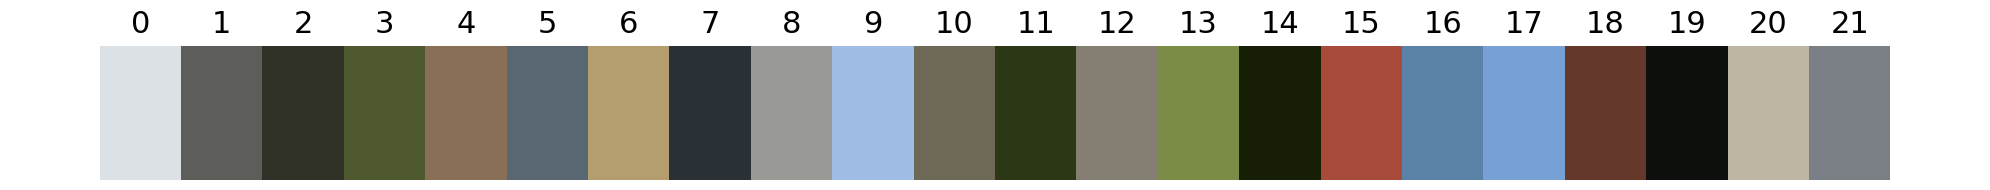

In [ ]:
colors = [v[:3] for k, v in sorted(merged_color_info_with_hex.items(), key=lambda x: int(x[0].replace('center', '')))]
fig, ax = plt.subplots(figsize=(20, 2))
for i, rgb in enumerate(colors):
    ax.bar(i, 1, color=rgb, width=1)
    ax.text(i, 1.05, str(i), ha='center', va='bottom', fontsize=22)


ax.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(FINAL_DIR, 'merged_color_card.png'), dpi=300, bbox_inches='tight')
plt.show()

### For example, to see the source of **red** (15):

In [ ]:
weather = "all" # candidates: "cloudy", "sunny", "all"
selected_semantics = [i for i in range(1, 19)]
selected_colors = [15]
fig = plot_selected_semantic_color_sankey(weather, selected_semantics, selected_colors)